In [1]:
import numpy as np
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from google.colab import drive
import glob
import os
import cv2
from google.colab.patches import cv2_imshow
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

drive.mount('/content/drive/')


Mounted at /content/drive/


In [51]:
#@title Select dataset

cell_line = 'Hs766T' #@param['HT29', 'Hs766T', 'Both']
evaluate = 'pi' #@param['dapi','pi']


def import_images(im, md, path, evaluate, reset = True):
  for img in os.listdir(path+'bf'):
    im.append(1-cv2.resize(cv2.imread(f"{path}bf/{img}")/255.0, (256,256)))
    aux_mask = cv2.resize(cv2.imread(f"{path}{evaluate}/{img}", cv2.IMREAD_GRAYSCALE), (256,256))
    md.append(aux_mask/np.max(aux_mask)) # normalise (0,1)

bf_images = []
dye_images = []

if cell_line == 'HT29':
  path = "/content/drive/MyDrive/Sopheriods/ExperimentSpheroidsHT29/"
  import_images(bf_images, dye_images, path, evaluate)
elif cell_line == 'Hs766T':
  path = "/content/drive/MyDrive/Sopheriods/ExperimentPancreas/"
  import_images(bf_images, dye_images, path, evaluate)
elif cell_line == 'Both':
  path = "/content/drive/MyDrive/Sopheriods/ExperimentSpheroidsHT29/"
  import_images(bf_images, dye_images, path, evaluate)
  path = "/content/drive/MyDrive/Sopheriods/ExperimentPancreas/"
  import_images(bf_images, dye_images, path, evaluate)

In [52]:
#@title Train-test split

X_train, X_test, y_train, y_test = train_test_split(bf_images, dye_images, test_size=0.33, random_state=4)

# Change format so that keras is happy (everything as np arrays, add an empty axis to y)
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train)
y_train = y_train[..., np.newaxis]
y_test = np.asarray(y_test)
y_test = y_test[..., np.newaxis]

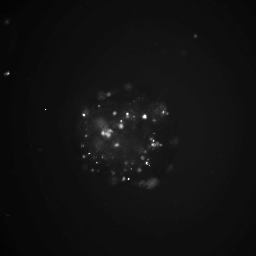

In [53]:
#@title Quick check 1: open one image of our Y train set:
cv2_imshow((y_train[3])*255)

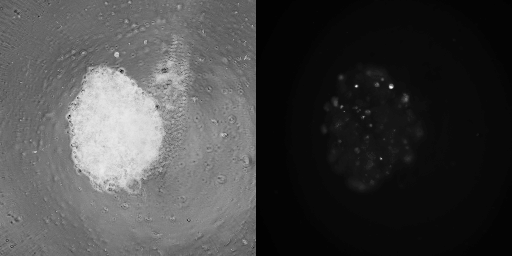

In [54]:
#@title Quick check 2: open one pair of images of our train set:
i = 2 #@param {type: "integer"}
cv2_imshow(np.concatenate(((X_train[i]*255).astype(np.uint8),cv2.cvtColor((y_train[i]*255).astype(np.uint8),cv2.COLOR_GRAY2RGB)), axis = 1))

In [55]:
y_train.shape

(20, 256, 256, 1)

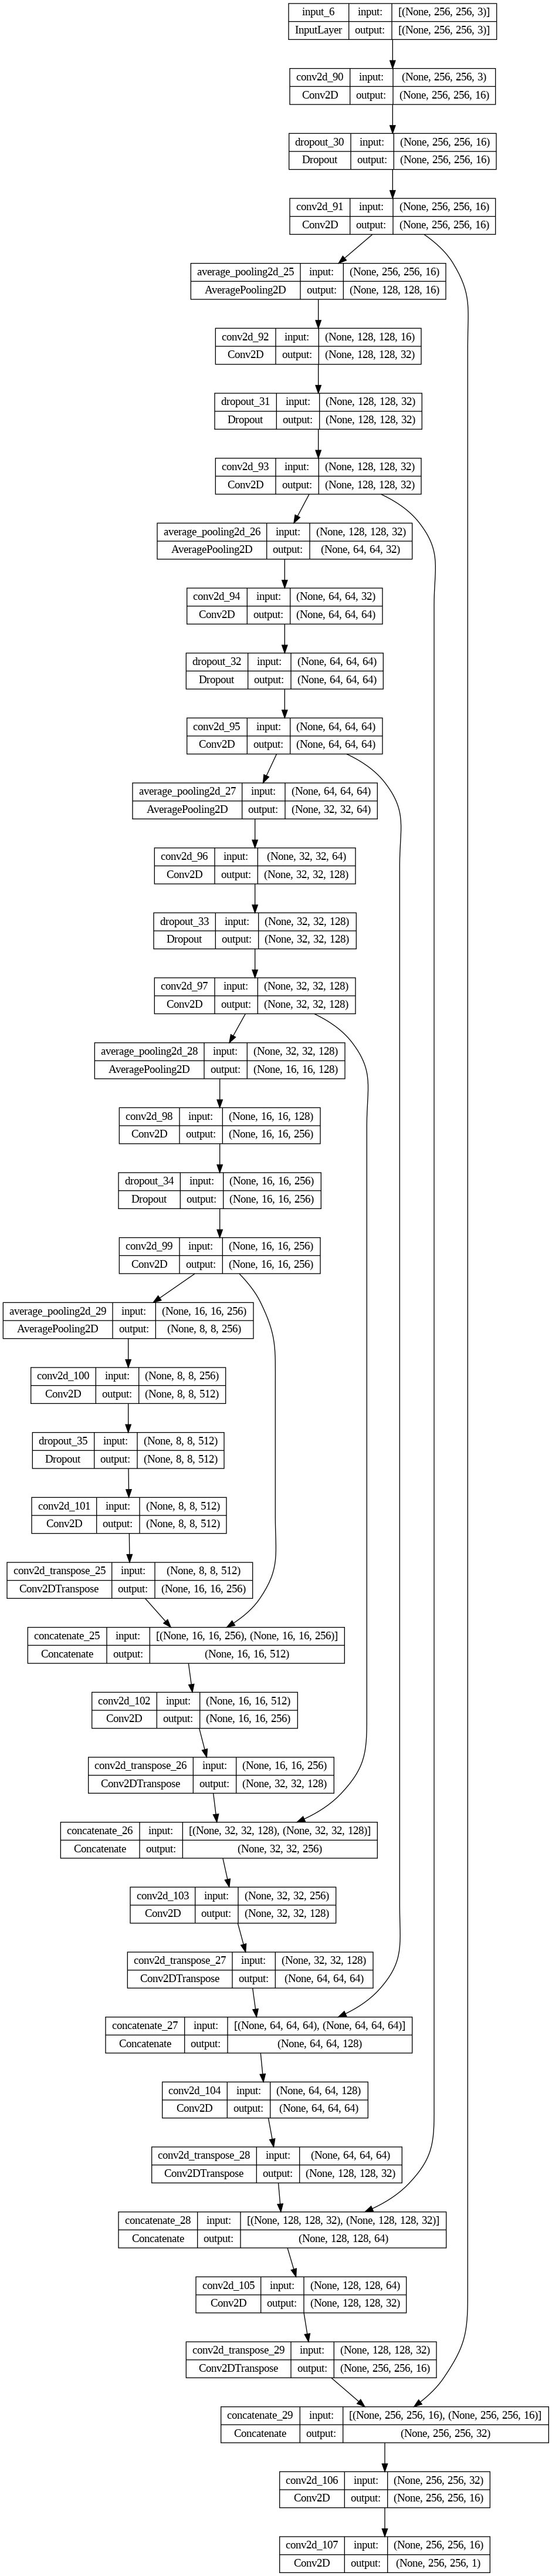

In [56]:
#@title Neural Network Setup

inputs = tf.keras.layers.Input(shape=(256, 256 ,3))

kernel_size = 3 # default = 3
pool_size = 2 # default = 2
#dropout = 0.3
#n_filters = # def: [16, 32, 64, 128, 256, 128, 64, 32, 16]

def encoder(inputs):
    c1 = tf.keras.layers.Conv2D(16, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.AveragePooling2D(pool_size = (2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.AveragePooling2D(pool_size = (2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.2)(c5)
    c5 = tf.keras.layers.Conv2D(256, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    p5 = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(c5)

    c6 = tf.keras.layers.Conv2D(512, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(p5)
    c6 = tf.keras.layers.Dropout(0.3)(c6)
    c6 = tf.keras.layers.Conv2D(512, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    return c6, c5, c4, c3, c2, c1

num_classes = 1
def decoder(c6, c5, c4, c3, c2, c1):
  u7 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
  u7 = tf.keras.layers.concatenate([u7, c5])
  c7 = tf.keras.layers.Conv2D(256, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(u7)
  #c7 = tf.keras.layers.Add()([u7, c7])

  u8 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
  u8 = tf.keras.layers.concatenate([u8, c4])
  c8 = tf.keras.layers.Conv2D(128, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(u8)
  #c8 = tf.keras.layers.Add()([u8, c8])

  u9 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
  u9 = tf.keras.layers.concatenate([u9, c3])
  c9 = tf.keras.layers.Conv2D(64, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(u9)
  #c9 = tf.keras.layers.Add()([u9, c9])

  u10 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c9)
  u10 = tf.keras.layers.concatenate([u10, c2])
  c10 = tf.keras.layers.Conv2D(32, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(u10)
  #c10 = tf.keras.layers.Add()([u10, c10])

  u11 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c10)
  u11 = tf.keras.layers.concatenate([u11, c1])
  c11 = tf.keras.layers.Conv2D(16, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(u11)
  #c11 = tf.keras.layers.Add()([u11, c11])

  outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(c11)
  return outputs

c6, c5, c4, c3, c2, c1 = encoder(inputs)
outputs = decoder(c6, c5, c4, c3, c2, c1)
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

#model.summary()
tf.keras.utils.plot_model(model, "model.png",show_shapes=True)

In [57]:
#@title Train Neural Network

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=50, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=["mean_squared_error"])

model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=1, epochs=70, callbacks=callbacks)


Epoch 1/70
20/20 [==============================] - 8s 58ms/step - loss: 0.3293 - mean_squared_error: 0.0377 - val_loss: 0.2539 - val_mean_squared_error: 0.0081
Epoch 2/70
20/20 [==============================] - 0s 20ms/step - loss: 0.2606 - mean_squared_error: 0.0102 - val_loss: 0.2484 - val_mean_squared_error: 0.0078
Epoch 3/70
20/20 [==============================] - 0s 21ms/step - loss: 0.2488 - mean_squared_error: 0.0069 - val_loss: 0.2544 - val_mean_squared_error: 0.0110
Epoch 4/70
20/20 [==============================] - 0s 21ms/step - loss: 0.2364 - mean_squared_error: 0.0049 - val_loss: 0.2332 - val_mean_squared_error: 0.0061
Epoch 5/70
20/20 [==============================] - 0s 21ms/step - loss: 0.2329 - mean_squared_error: 0.0046 - val_loss: 0.2225 - val_mean_squared_error: 0.0038
Epoch 6/70
20/20 [==============================] - 0s 21ms/step - loss: 0.2260 - mean_squared_error: 0.0037 - val_loss: 0.2231 - val_mean_squared_error: 0.0044
Epoch 7/70
20/20 [================

In [60]:
#@title Save model
#model.save(f"cont_unet_{cell_line}_{evaluate}.keras")
model.save(f"cont_unet_{cell_line}_{evaluate}.h5")

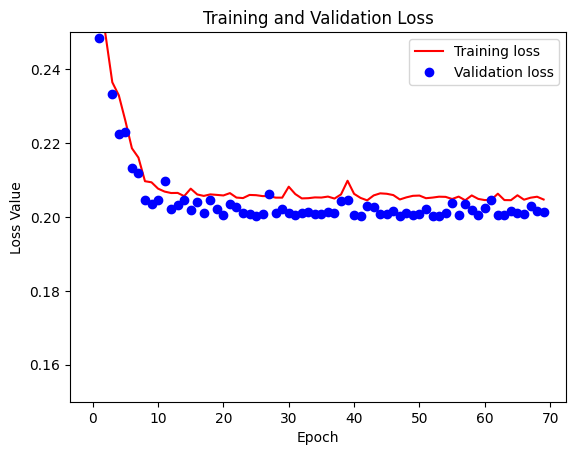

In [58]:
#@title Training / Validation Loss curve

loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

plt.figure()
plt.plot( loss, 'r', label='Training loss')
plt.plot( val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0.15, 0.25])
plt.legend()
plt.show()

1/1 [==============================] - 0s 344ms/step


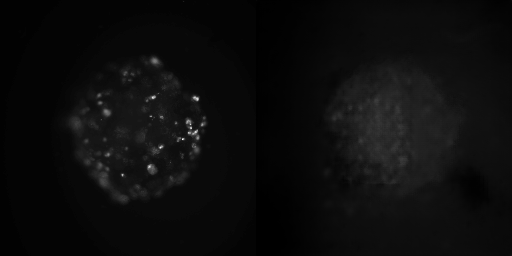

[[0.6341735]]


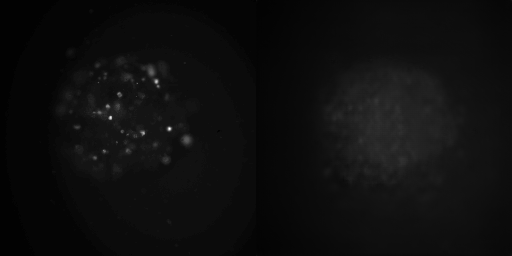

[[0.723344]]


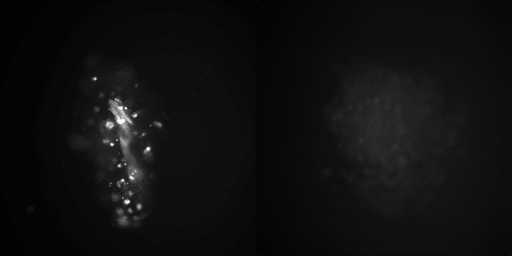

[[0.64852196]]


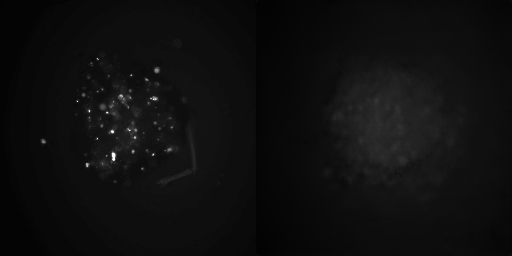

[[0.5959883]]


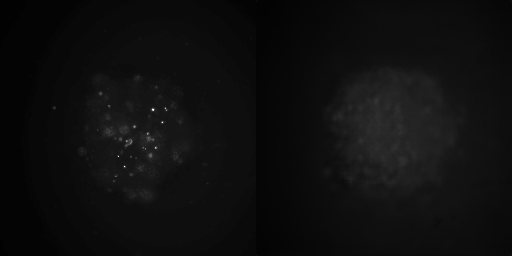

[[0.8123389]]


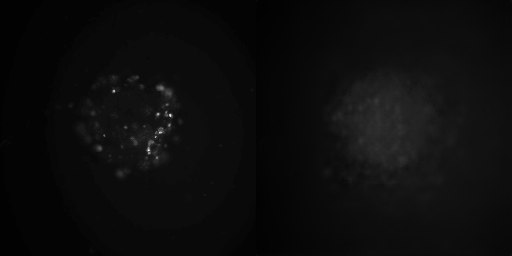

[[0.6969726]]


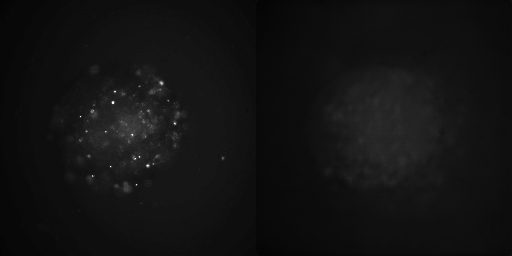

[[0.7879169]]


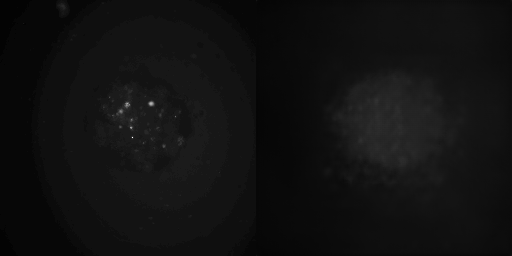

[[0.7543983]]


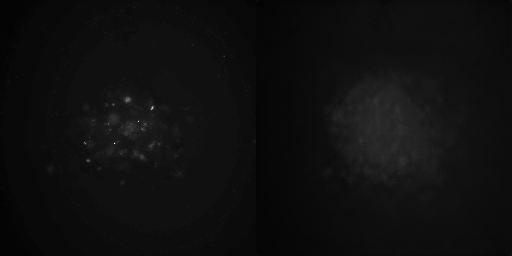

[[0.7928619]]


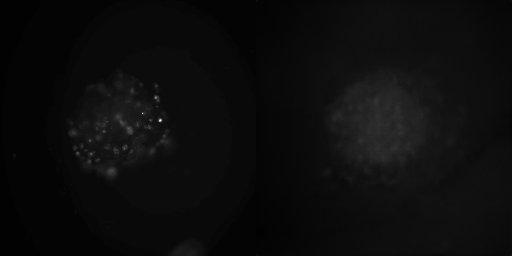

[[0.8070096]]


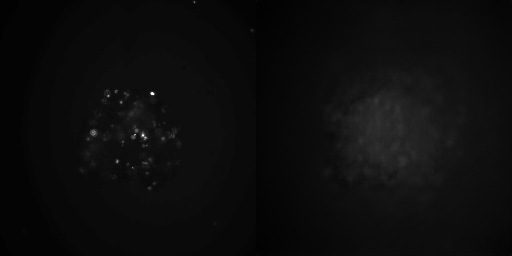

[[0.6254939]]


0.7162745

In [59]:
#@title Generate predictions and validate with NCCoeff

y_pred = model.predict(np.asarray(X_test))

succ = []
for i in range(len(y_pred)):
  cv2_imshow(np.concatenate((y_test[i], y_pred[i]), axis = 1)*255)
  mt = cv2.matchTemplate(np.uint8(y_pred[i]*255), np.uint8(y_test[i]*255), method = cv2.TM_CCOEFF_NORMED)

  print(mt)
  succ.append(mt)

np.average(succ)